<a href="https://colab.research.google.com/github/Lipika18/DBT_training/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install vaderSentiment

In [72]:
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [73]:
# --------------------------
# 1. Load and Inspect Data
# --------------------------
data = pd.read_excel("review.xlsx")
print("Initial Data:")
print(data.head(5))

Initial Data:
       id  workId                                                url  \
0  155870     196  https://myanimelist.net/anime/196/Onegai%E2%98...   
1  245390     934  https://myanimelist.net/anime/934/Higurashi_no...   
2  269080    3229  https://myanimelist.net/anime/3229/Kimi_ga_Aru...   
3  280755    1682  https://myanimelist.net/anime/1682/Baldr_Force...   
4  291553    1751  https://myanimelist.net/anime/1751/Jikuu_Bouke...   

                              workName     postTime episodesSeen  \
0                 Onegai%E2%98%86Twins  Apr 1, 2008          NaN   
1            Higurashi_no_Naku_Koro_ni  Apr 1, 2008          NaN   
2  Kimi_ga_Aruji_de_Shitsuji_ga_Ore_de  Apr 1, 2008          NaN   
3           Baldr_Force_Exe_Resolution  Apr 1, 2008          NaN   
4             Jikuu_Bouken_Nuumamonjaa  Apr 1, 2008          NaN   

   overallRating        author  reviewId  \
0              7      CapitalJ      3533   
1             10       merQree      3538   
2           

In [74]:
# Function to clean the text
def clean_text(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text) # Remove unwanted line breaks, spaces, and excess whitespace
    text = re.sub(r'&[a-zA-Z]+;', '', text) # Remove &quot; or other HTML-like entities
    text = re.sub(r'\.{2,}', '.', text) # Remove extra ellipses or multiple dots
    text = re.sub(r'[^\w\s.,:;!?\'"-]', '', text) # Remove unnecessary symbols, e.g., emoticons (;p) or stray non-word characters
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space
    text = text.strip() # Clean up and strip leading/trailing spaces
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

In [75]:
# Apply cleaning to the reviews
data["cleaned_reviews"] = data["review"].apply(clean_text)

print("\nCleaned Reviews:")
print(data.head())


Cleaned Reviews:
       id  workId                                                url  \
0  155870     196  https://myanimelist.net/anime/196/Onegai%E2%98...   
1  245390     934  https://myanimelist.net/anime/934/Higurashi_no...   
2  269080    3229  https://myanimelist.net/anime/3229/Kimi_ga_Aru...   
3  280755    1682  https://myanimelist.net/anime/1682/Baldr_Force...   
4  291553    1751  https://myanimelist.net/anime/1751/Jikuu_Bouke...   

                              workName     postTime episodesSeen  \
0                 Onegai%E2%98%86Twins  Apr 1, 2008          NaN   
1            Higurashi_no_Naku_Koro_ni  Apr 1, 2008          NaN   
2  Kimi_ga_Aruji_de_Shitsuji_ga_Ore_de  Apr 1, 2008          NaN   
3           Baldr_Force_Exe_Resolution  Apr 1, 2008          NaN   
4             Jikuu_Bouken_Nuumamonjaa  Apr 1, 2008          NaN   

   overallRating        author  reviewId  \
0              7      CapitalJ      3533   
1             10       merQree      3538   
2       

In [76]:
# --------------------------
# 2. Sentiment Analysis using VADER
# --------------------------
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    """Returns sentiment label based on polarity score."""
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [77]:
# Apply sentiment labeling to the reviews
data["sentiment"] = data["cleaned_reviews"].apply(get_sentiment)

In [78]:

# Convert sentiment labels to numeric for SVM
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
data['sentiment_label'] = data['sentiment'].map(sentiment_mapping)

# Remove rows with missing sentiment labels
data = data.dropna(subset=['sentiment_label'])

In [79]:
# --------------------------
# 3. Feature Extraction using TF-IDF
# --------------------------

# Initialize the vectorizer with a limit on the number of features
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the text data
X = vectorizer.fit_transform(data["cleaned_reviews"])

# Assign the sentiment labels
y = data["sentiment_label"]

print(X.toarray()) # TF-IDF feature matrix
print(y) # Sentiment labels

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.04414906 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
0       1
1      -1
2       1
3       1
4       1
       ..
9859    1
9860    1
9861    1
9862   -1
9863    1
Name: sentiment_label, Length: 9864, dtype: int64


In [80]:
# Feature names
print(vectorizer.get_feature_names_out())


['abandoned' 'abilities' 'ability' ... 'zombie' 'zombies' 'zone']


In [81]:
# --------------------------
# 4. Split Data into Train and Test Sets
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# SMOTE (Synthetic Minority Over-sampling Technique) is used to oversample the minority classes in the training data.


X represents the features of your dataset (e.g., TF-IDF features).

y represents the labels (e.g., sentiment labels).

The parameters used in train_test_split:

test_size=0.2: This specifies that 20% of the data should be used as the test set, and the remaining 80% will be the training set.

random_state=42: This is a seed value to ensure the split is reproducible. Any time you run this code with the same random state, you will get the same train-test split.

stratify=y: This ensures that the split maintains the same proportion of classes in both the training and test sets as in the original dataset. It's useful when you have imbalanced classes.

In [82]:
# # Shows the number of training samples and features.
# print("X_train shape:", X_train.shape)

# # Shows the number of test samples and features.
# print("X_test shape:", X_test.shape)

# # Displays the count of each sentiment label in the training set.
# print("y_train distribution:\n", y_train.value_counts())

# # Displays the count of each sentiment label in the test set.
# print("y_test distribution:\n", y_test.value_counts())

# Check the shapes
print("Resampled X_train shape:", X_train_resampled.shape)
print("Resampled y_train shape:", y_train_resampled.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# Check the distribution of labels
print("Resampled y_train distribution:\n", y_train_resampled.value_counts())
print("y_test distribution:\n", y_test.value_counts())

Resampled X_train shape: (22251, 5000)
Resampled y_train shape: (22251,)
X_test shape: (1973, 5000)
y_test shape: (1973,)
Resampled y_train distribution:
 sentiment_label
 1    7417
-1    7417
 0    7417
Name: count, dtype: int64
y_test distribution:
 sentiment_label
 1    1854
-1     112
 0       7
Name: count, dtype: int64


In [83]:
# --------------------------
# 5. Train the SVM Model
# --------------------------
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)


SVC(kernel='linear', random_state=42)

SVM (Support Vector Machine): This is a type of machine learning model used for classification tasks, which means it helps to categorize data into different classes (like positive, negative, and neutral sentiments in your case).

You create a machine learning model (svm_model) that knows how to classify text data.

Then, you teach this model using your training data (X_train_resampled and y_train_resampled), so it learns to recognize patterns and can later predict the sentiment of new text data.

In [84]:
# --------------------------
# 6. Evaluate the SVM Model
# --------------------------
y_pred = svm_model.predict(X_test) #This function uses the trained SVM model to predict the sentiment labels for the test features (X_test).

# Print evaluation metrics
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Accuracy Score: 0.9406994424733908

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.49      0.50       112
     Neutral       0.00      0.00      0.00         7
    Positive       0.97      0.97      0.97      1854

    accuracy                           0.94      1973
   macro avg       0.49      0.49      0.49      1973
weighted avg       0.94      0.94      0.94      1973



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
# --------------------------
# 7. Predict Sentiments for All Reviews
# --------------------------
data['predicted_sentiment'] = svm_model.predict(X)

# Convert predictions back to sentiment labels
reverse_mapping = {1: 'positive', -1: 'negative', 0: 'neutral'}
data['predicted_sentiment'] = data['predicted_sentiment'].map(reverse_mapping)

In [86]:
# --------------------------
# 8. Group Sentiments by Anime
# --------------------------
# One-hot encode predictions
data['positive'] = (data['predicted_sentiment'] == 'positive').astype(int)
data['negative'] = (data['predicted_sentiment'] == 'negative').astype(int)
data['neutral'] = (data['predicted_sentiment'] == 'neutral').astype(int)

In [87]:
data.head(5)

,id,workId,url,workName,postTime,episodesSeen,overallRating,author,reviewId,review,...,informative,wellWritten,creative,cleaned_reviews,sentiment,sentiment_label,predicted_sentiment,positive,negative,neutral
0,155870,196,https://myanimelist.net/anime/196/Onegai%E2%98...,Onegai%E2%98%86Twins,"Apr 1, 2008",NaN,7,CapitalJ,3533,The plot is pretty interesting at first but I ...,...,0,0,0,the plot is pretty interesting at first but i ...,positive,1,positive,1,0,0
1,245390,934,https://myanimelist.net/anime/934/Higurashi_no...,Higurashi_no_Naku_Koro_ni,"Apr 1, 2008",NaN,10,merQree,3538,I haven't watched many anime's yet but so far ...,...,0,0,0,i havent watched many animes yet but so far th...,negative,-1,negative,0,1,0
2,269080,3229,https://myanimelist.net/anime/3229/Kimi_ga_Aru...,Kimi_ga_Aruji_de_Shitsuji_ga_Ore_de,"Apr 1, 2008",NaN,8,Master10K,3525,"They Are My Noble Masters is a Harem, Ecchi, R...",...,0,0,0,they are my noble masters is a harem ecchi rom...,positive,1,positive,1,0,0
3,280755,1682,https://myanimelist.net/anime/1682/Baldr_Force...,Baldr_Force_Exe_Resolution,"Apr 1, 2008",NaN,9,Spades-Deuce,3528,BALDR FORCE EXE Resolution is one of the those...,...,0,0,0,baldr force exe resolution is one of the those...,positive,1,positive,1,0,0
4,291553,1751,https://myanimelist.net/anime/1751/Jikuu_Bouke...,Jikuu_Bouken_Nuumamonjaa,"Apr 1, 2008",NaN,8,Virgil,3526,This is actually one of my favorite comedy-bas...,...,0,0,0,this is actually one of my favorite comedybase...,positive,1,positive,1,0,0


In [88]:
# Group by anime_name
grouped_sentiments = data.groupby('workName')[['positive', 'negative', 'neutral']].sum().reset_index()
grouped_sentiments['total_reviews'] = grouped_sentiments[['positive', 'negative', 'neutral']].sum(axis=1)
grouped_sentiments.head(50)

,workName,positive,negative,neutral,total_reviews
0,1,1,0,0,1
1,86,4,2,0,6
2,%C4%93lDLIVE,1,0,0,1
3,00_08,2,0,0,2
4,07-Ghost,6,0,0,6
5,100-man_no_Inochi_no_Ue_ni_Ore_wa_Tatteiru,0,1,0,1
6,100-man_no_Inochi_no_Ue_ni_Ore_wa_Tatteiru_2nd...,2,0,0,2
7,11eyes,2,1,0,3
8,180_Byou_de_Kimi_no_Mimi_wo_Shiawase_ni_Dekiru_ka,1,0,0,1
9,18if,1,0,0,1


In [90]:
# Calculate sentiment ratios
grouped_sentiments['positive_ratio'] = grouped_sentiments['positive'] / grouped_sentiments['total_reviews']
grouped_sentiments['negative_ratio'] = grouped_sentiments['negative'] / grouped_sentiments['total_reviews']
grouped_sentiments['neutral_ratio'] = grouped_sentiments['neutral'] / grouped_sentiments['total_reviews']
grouped_sentiments.head(10)

,workName,positive,negative,neutral,total_reviews,positive_ratio,negative_ratio,neutral_ratio
0,1,1,0,0,1,1.000000,0.000000,0.0
1,86,4,2,0,6,0.666667,0.333333,0.0
2,%C4%93lDLIVE,1,0,0,1,1.000000,0.000000,0.0
3,00_08,2,0,0,2,1.000000,0.000000,0.0
4,07-Ghost,6,0,0,6,1.000000,0.000000,0.0
5,100-man_no_Inochi_no_Ue_ni_Ore_wa_Tatteiru,0,1,0,1,0.000000,1.000000,0.0
6,100-man_no_Inochi_no_Ue_ni_Ore_wa_Tatteiru_2nd...,2,0,0,2,1.000000,0.000000,0.0
7,11eyes,2,1,0,3,0.666667,0.333333,0.0
8,180_Byou_de_Kimi_no_Mimi_wo_Shiawase_ni_Dekiru_ka,1,0,0,1,1.000000,0.000000,0.0
9,18if,1,0,0,1,1.000000,0.000000,0.0


In [91]:
import matplotlib.pyplot as plt

<ipython-input-92-00a42516acef>:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

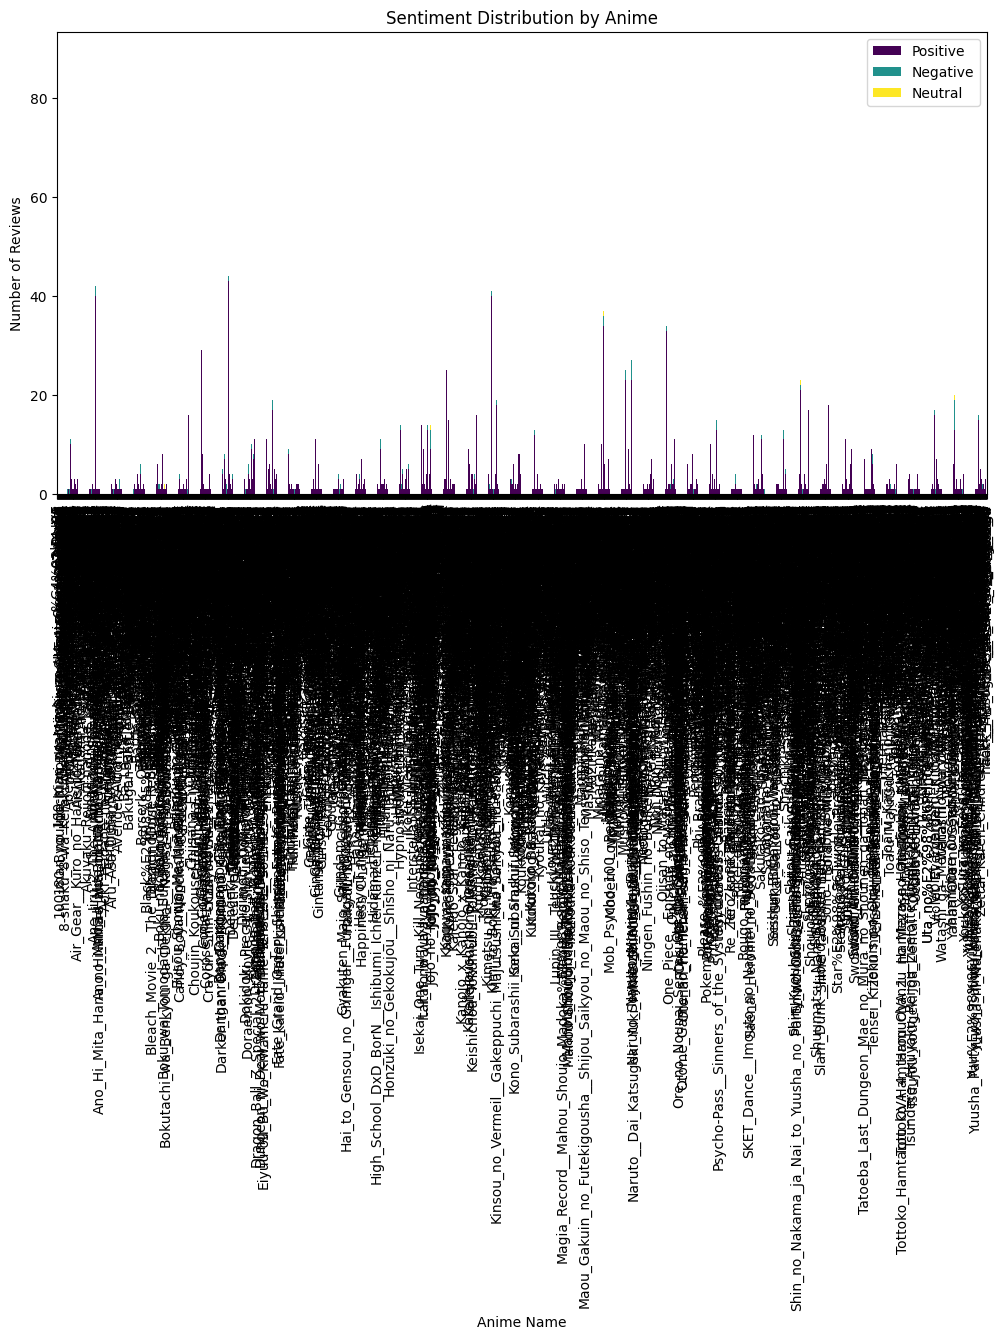

In [92]:
# --------------------------
# 9. Visualize Sentiment Distribution
# --------------------------
plt.figure(figsize=(12, 6))
grouped_sentiments.set_index('workName')[['positive', 'negative', 'neutral']].plot(
    kind='bar', stacked=True, colormap='viridis', figsize=(12, 6)
)
plt.title("Sentiment Distribution by Anime")
plt.xlabel("Anime Name")
plt.ylabel("Number of Reviews")
plt.legend(["Positive", "Negative", "Neutral"])
plt.tight_layout()
plt.show()

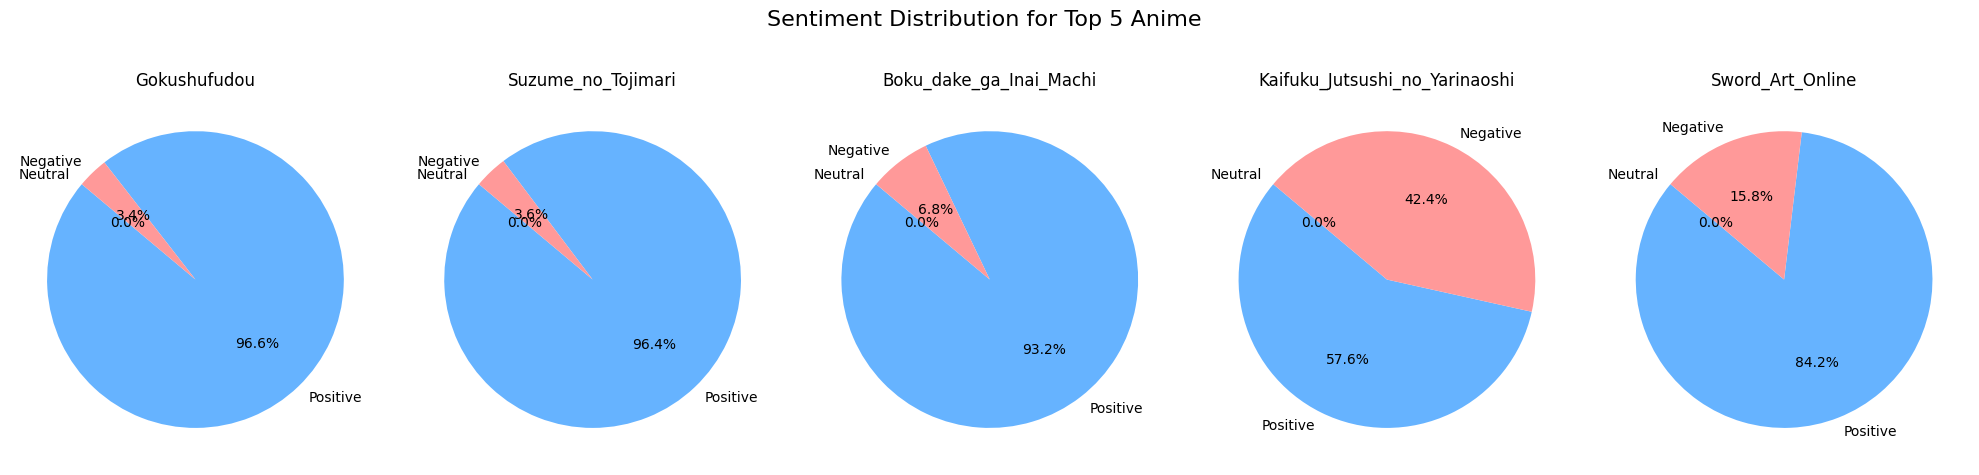

In [93]:
top_anime = grouped_sentiments.sort_values(by='total_reviews', ascending=False).head(5)

# Plot pie charts for each anime
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle("Sentiment Distribution for Top 5 Anime", fontsize=16)

for i, anime in enumerate(top_anime['workName']):
    ax = axes[i]
    anime_data = top_anime[top_anime['workName'] == anime][['positive', 'negative', 'neutral']].iloc[0]
    labels = ['Positive', 'Negative', 'Neutral']
    values = anime_data.values
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999', '#99ff99'])
    ax.set_title(anime)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
